In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/"


'Colab Notebooks'   OwlDetection


Found 912 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


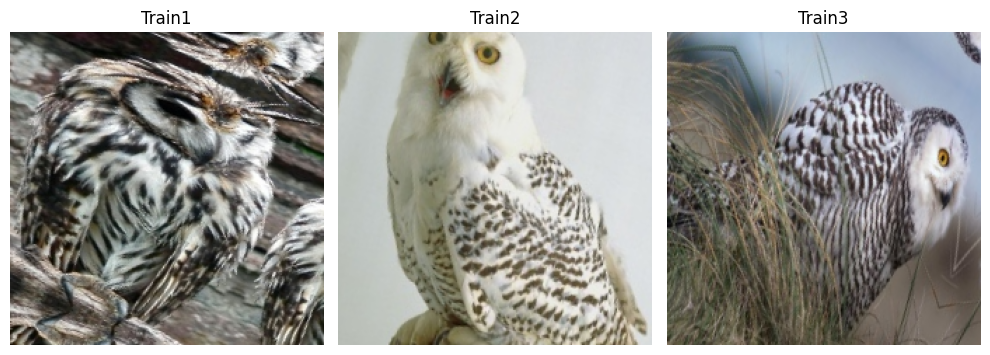

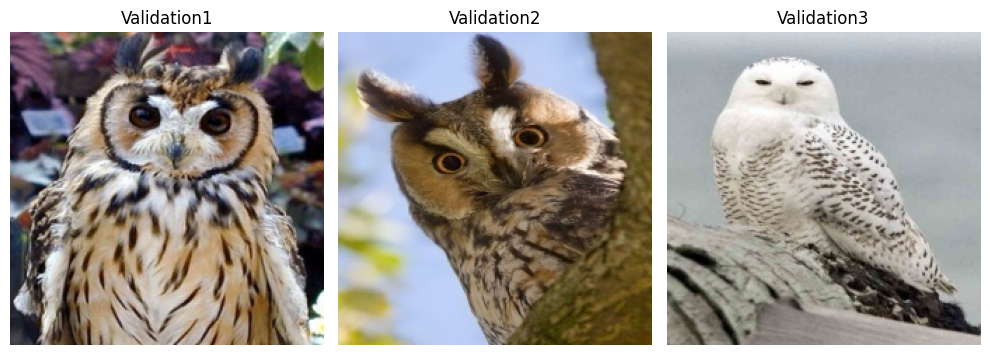

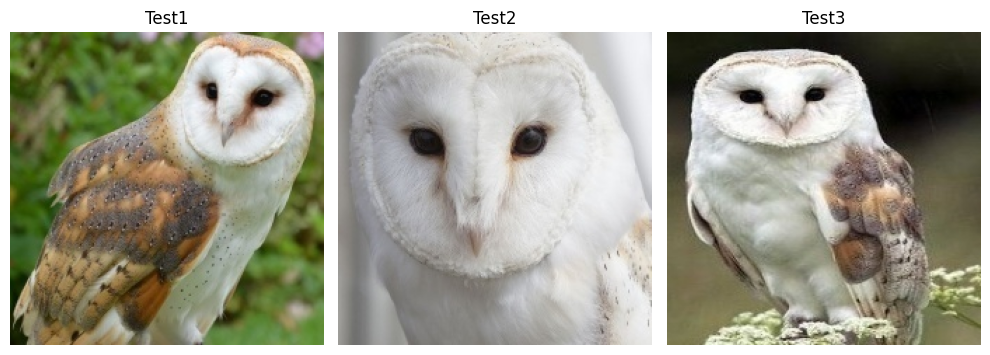

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random

# Set some parameters
img_height, img_width = 224, 224
batch_size = 88

# Set up the training, validation, and test directories
train_dir = '/content/drive/MyDrive/OwlDetection/train'
validation_dir = '/content/drive/MyDrive/OwlDetection/valid'
test_dir = '/content/drive/MyDrive/OwlDetection/test'

# Set up data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Note that validation and test data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # 'categorical' because we have more than 2 classes
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Helper function to plot images
def plot_images(images_arr, titles):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(10,10))
    axes = axes.flatten()
    for img, ax, title in zip(images_arr, axes, titles):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Displaying images from each generator
# Extract and plot a batch from each
train_images, _ = next(train_generator)
validation_images, _ = next(validation_generator)
test_images, _ = next(test_generator)

# We take the first three images of the batch
plot_images(train_images[:3], ['Train1', 'Train2', 'Train3'])
plot_images(validation_images[:3], ['Validation1', 'Validation2', 'Validation3'])
plot_images(test_images[:3], ['Test1', 'Test2', 'Test3'])


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

print(len(base_model.layers))

for layer in base_model.layers[:143]:
  layer.trainable = False

for i, layer in enumerate(base_model.layers):
  print(i, layer.name, "-", layer.trainable)

# Create a new model on top of the pre-trained ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(6, activation='softmax')
])

model.summary()


94765736/94765736 [==============================] - 5s 0us/step
175
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam

# Define the learning rate schedule function
def lr_schedule(epoch):
    if epoch < 20:
        return 0.0001
    else:
        return 0.00005

# Initialize the optimizer with the initial learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=None,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30
10/10 [==============================] - 523s 50s/step - loss: 1.9979 - accuracy: 0.2816 - val_loss: 1.8720 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/30
10/10 [==============================] - 15s 2s/step - loss: 1.7394 - accuracy: 0.3908 - val_loss: 1.8360 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/30
10/10 [==============================] - 15s 1s/step - loss: 1.5695 - accuracy: 0.4090 - val_loss: 1.8121 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 4/30
10/10 [==============================] - 16s 1s/step - loss: 1.4100 - accuracy: 0.5049 - val_loss: 1.7980 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 5/30
10/10 [==============================] - 16s 2s/step - loss: 1.3262 - accuracy: 0.5080 - val_loss: 1.8115 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 6/30
10/10 [==============================] - 16s 2s/step - loss: 1.2629 - accuracy: 0.5449 - val_loss: 1.8200 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 7/30
10/10 [==============================] - 15s 

1/1 [==============================] - 0s 277ms/step - loss: 0.7751 - accuracy: 0.7667
Test accuracy: 0.7666666507720947


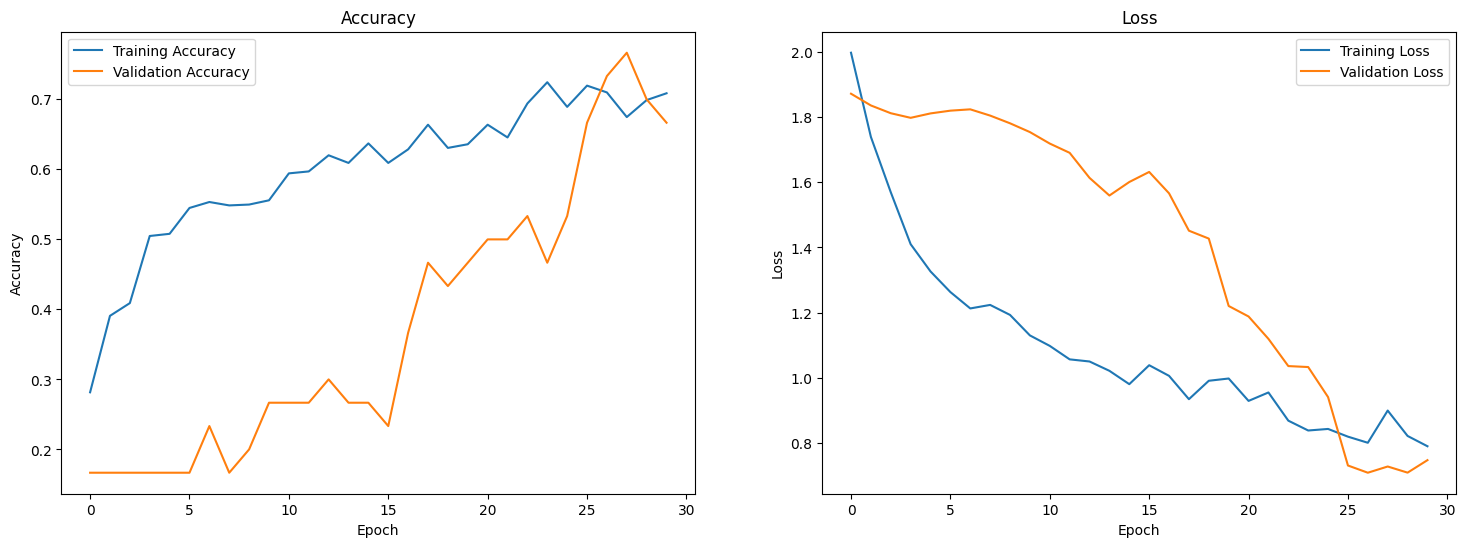

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=None)
print('Test accuracy:', test_acc)

# Plot training history
plt.figure(figsize=(18, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.show()